In [1]:
import jax
import jax.numpy as jnp
from ml_collections import config_flags
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ddprism.corrupted_mnist import datasets
from ddprism.metrics import metrics, image_metrics
from ddprism.corrupted_mnist import config_base_grass
from ddprism.corrupted_mnist import config_base_mnist


from pcpca import PCPCA

2025-07-16 13:26:15.597438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752686775.612870 3378592 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752686775.617586 3378592 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752686775.630241 3378592 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752686775.630259 3378592 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752686775.630260 3378592 computation_placer.cc:177] computation placer alr

In [2]:
imagenet_path = '/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/dataset/grass_jpeg/' 



## 1. Load grass and MNIST + grass datasets

### 1.1 Training set

In [3]:
# Generate train dataset with corrupted mnist digits.
config_mnist = config_base_mnist.get_config()
rng = jax.random.key(config_mnist.rng_key)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)

f_train = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=1., mnist_amp=config_mnist.mnist_amp,
    imagenet_path=imagenet_path,
    dataset_size=config_mnist.dataset_size,
    zeros_and_ones=True
)

# Generate train dataset with uncorrupted mnist digits for computing metrics later on.
f_train_uncorrupted = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=0., mnist_amp=1.,
    imagenet_path=imagenet_path,
    dataset_size=config_mnist.dataset_size,
    zeros_and_ones=True
)

In [4]:
# Generate train dataset with grass
config = config_base_grass.get_config()
rng = jax.random.key(config.rng_key)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)
b_train = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=1., mnist_amp=0.,
    imagenet_path=imagenet_path, 
    dataset_size=config.dataset_size,
    zeros_and_ones=True)



### 1.2 Validation set

In [5]:
# Generate validation dataset with corrupted mnist digits.
rng = jax.random.key(config_mnist.rng_key_val)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)

# Corrupted
f_val = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=1., mnist_amp=config_mnist.mnist_amp,
    imagenet_path=imagenet_path,
    dataset_size=14720, 
    zeros_and_ones=True
)
# Take previously unseen digits for the validation set
f_val_images = f_val[0][config_mnist.dataset_size:]
f_val_labels = f_val[1][config_mnist.dataset_size:]
f_val = (f_val_images, f_val_labels)

# Generate validation dataset with uncorrupted mnist digits for computing metrics later on.
f_val_uncorrupted = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=0., mnist_amp=1.,
    imagenet_path=imagenet_path,
    dataset_size=14720, 
    zeros_and_ones=True
)
# Take previously unseen digits for the validation set
f_val_images = f_val_uncorrupted[0][config_mnist.dataset_size:]
f_val_labels = f_val_uncorrupted[1][config_mnist.dataset_size:]
f_val_uncorrupted = (f_val_images, f_val_labels)



## 2. Fit PCPCA

In [105]:
from ddprism.pcpca import pcpca_utils
import importlib
importlib.reload(pcpca_utils)

<module 'ddprism.pcpca.pcpca_utils' from '/mnt/home/aakhmetzhanova/ddprism/ddprism/pcpca/pcpca_utils.py'>

In [110]:
def calculate_posterior(params, x_obs, regularization=1e-6):
    """Calculate the mean and covariance for the signal posterior.

    Args:
        params: Parameters of the PCPCA model. Dict with keys 'weights' and
            'log_sigma'.
        y_obs: Observed data with enriched signal.
        regularization: Small value to add to diagonal for numerical stability.

    Returns:
        Tuple of mean and covariance for the signal posterior.

    Notes:
        See paper for derivation.
    """
    weights, log_sigma, mu = (
        params['weights'], params['log_sigma'], params['mu']
    )
    sigma_sq = jnp.exp(2 * log_sigma)

    # First compute the covariance matrix.
    prior_precision = jnp.linalg.inv(
        weights @ weights.T + regularization * jnp.eye(weights.shape[0])
    )
    sigma_post = jnp.linalg.inv(
        (1/sigma_sq) * jnp.eye(weights.shape[0]) + prior_precision
    )
    

    # Compute posterior mean
    mean_post = sigma_post @ (
        1 / sigma_sq * x_obs.T + prior_precision @ mu[..., None]
    )
    
    return mean_post.T, sigma_post

def posterior_samples(rng, dataset, params):
    """Computes posterior samples for a given target dataset, given a dictionary of pcpca parameters.
    
    Returns:
        Posterior samples.
    
    """
    # Load foreground dataset and flatten images
    x, x_labels = dataset
    x = x.squeeze(-1).reshape(-1, 784)
    
    mean_post, sigma_post = calculate_posterior(params, x, regularization=1e-6)
    post_samples = jax.random.multivariate_normal(rng, mean=mean_post, cov=sigma_post, method='svd')
    
    return post_samples


In [120]:

X, X_labels = f_train
X = X.squeeze(-1).reshape(-1, 784)

Y, Y_labels = b_train
Y = Y.squeeze(-1).reshape(-1, 784)

# Fit PCPCA
gamma=0.385
latent_dim=2
params = pcpca_utils.mle_params(X, Y, gamma, latent_dim, sigma=config.sigma_y);

(13824, 784) -0.3980219 1.6526734 0.5066822


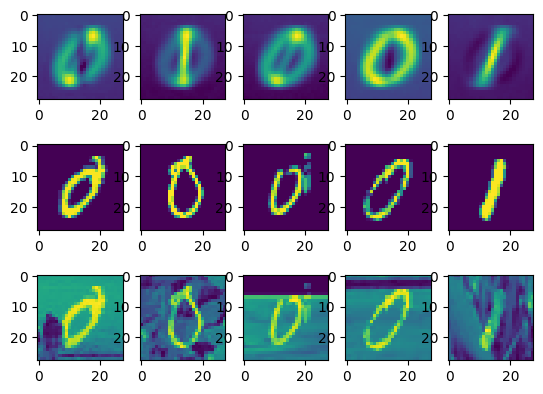

In [121]:
# Compute posterior samples
rng_post, rng = jax.random.split(rng, 2)
post_samples_train = posterior_samples(rng_post, f_train, params)
print(post_samples_train.shape, post_samples_train.min(), post_samples_train.max(), post_samples_train.mean())

# Plot posterior samples
n_rows, n_cols = 3, 5
rng_img, rng = jax.random.split(rng, 2)
idx = jax.random.randint(rng_img, shape=(n_cols), minval=0, maxval=post_samples_train.shape[0])

fig, axs = plt.subplots(n_rows, n_cols)
for col in range(n_cols):
    axs[0, col].imshow(post_samples_train.reshape(-1, 28, 28, 1)[idx[col]])
    axs[1, col].imshow(f_train_uncorrupted[0][idx[col]])
    axs[2, col].imshow(f_train[0][idx[col]])
plt.show()



In [122]:
f_train[0].mean(), b_train[0].mean(), (post_samples_train).mean()

(Array(0.50671196, dtype=float32),
 Array(0.44711894, dtype=float32),
 Array(0.5066822, dtype=float32))

## 3. Compute metrics on the training and validatin sets

In [113]:
# Load classifier model to compute FCD
from orbax.checkpoint import CheckpointManager, PyTreeCheckpointer
from pathlib import Path

workdir=Path('/mnt/home/swagner/ceph/corrupted_mnist/mnist_classifier/')
checkpointer = PyTreeCheckpointer()
checkpoint_manager = CheckpointManager(workdir, checkpointer
    )

model = image_metrics.CNN()
classifier_params = checkpoint_manager.restore(checkpoint_manager.latest_step())['params'] 
checkpoint_manager.close()

/mnt/home/aakhmetzhanova/venv/jax-env/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [114]:
# Compute metrics on the training set.
print('Training set')

n_draws = 10
fcd = []

for _n in range(n_draws):
    rng, _ = jax.random.split(rng)
    post_samples_train  = posterior_samples(rng, f_train, params) 
    post_samples_train  = post_samples_train.reshape(-1, 28, 28, 1)

    fcd.append(image_metrics.fcd_mnist(model, classifier_params, f_train[0], post_samples_train))
    print(f'Posterior Samples: FCD = {fcd[-1]:.4f}')
    
print(f'\n FCD: {np.array(fcd).mean():.4f} \pm {np.array(fcd).std():.4f}')


Training set
Posterior Samples: FCD = 3.1421
Posterior Samples: FCD = 3.1424
Posterior Samples: FCD = 3.1421
Posterior Samples: FCD = 3.1416
Posterior Samples: FCD = 3.1415
Posterior Samples: FCD = 3.1418
Posterior Samples: FCD = 3.1437
Posterior Samples: FCD = 3.1436
Posterior Samples: FCD = 3.1425
Posterior Samples: FCD = 3.1440

 FCD: 3.1425 \pm 0.0009


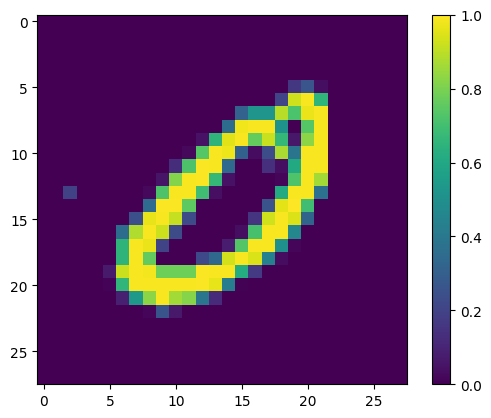

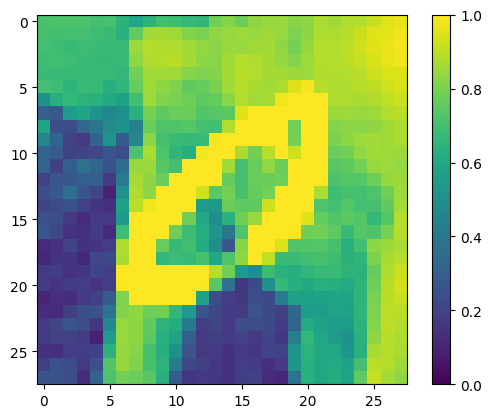

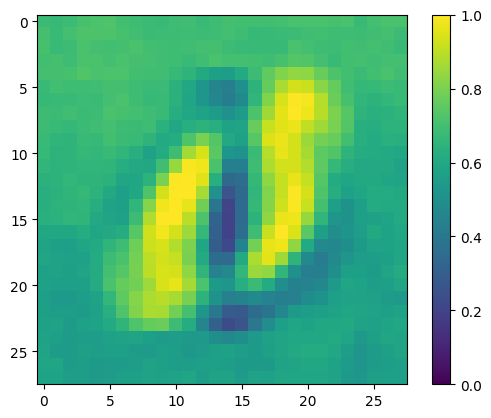

In [115]:
# Compare the true uncorrupted digits with draws from the posterior.
idx = 122
plt.figure(0)
plt.imshow(f_train_uncorrupted[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

plt.figure(1)
plt.imshow(f_train[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

plt.figure(2)
plt.imshow(post_samples_train[idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

In [116]:
# Compute metrics on the vslidation set set
print('\nValidation set')

n_draws = 10
fcd = []

post_samples_val_draws = []

for _n in range(n_draws):
    rng, _ = jax.random.split(rng)
    post_samples_val  = posterior_samples(rng, f_val, params) 
    post_samples_val  = post_samples_val.reshape(-1, 28, 28, 1)

    fcd.append(image_metrics.fcd_mnist(model, classifier_params, f_val[0], post_samples_val))
    
    print(f'Posterior Samples: FCD = {fcd[-1]:.4f}')

print(f'\n FCD: {np.array(fcd).mean():.4f} \pm {np.array(fcd).std():.4f}')



Validation set
Posterior Samples: FCD = 4.9675
Posterior Samples: FCD = 4.9680
Posterior Samples: FCD = 4.9592
Posterior Samples: FCD = 4.9662
Posterior Samples: FCD = 4.9654
Posterior Samples: FCD = 4.9693
Posterior Samples: FCD = 4.9611
Posterior Samples: FCD = 4.9665
Posterior Samples: FCD = 4.9621
Posterior Samples: FCD = 4.9693

 FCD: 4.9655 \pm 0.0033


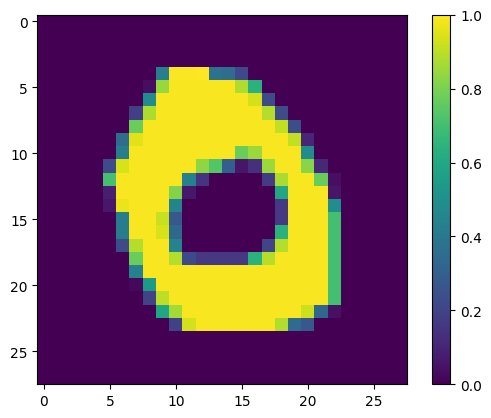

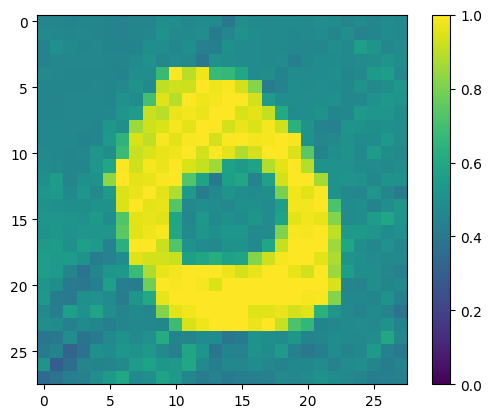

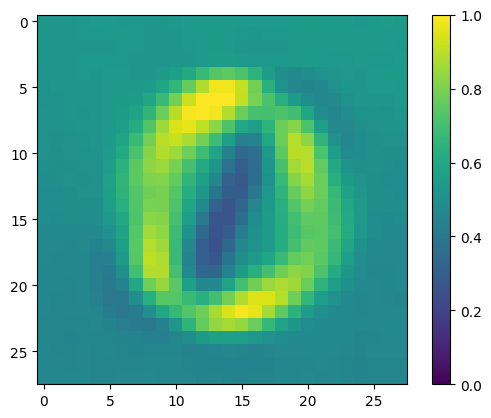

In [117]:
# Compare the true uncorrupted digits with draws from the posterior.
idx = 95
plt.figure(0)
plt.imshow(f_val_uncorrupted[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

plt.figure(1)
plt.imshow(f_val[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

plt.figure(2)
plt.imshow(post_samples_val[idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()